# Generate Random Art with a Neural Network #
### Tuan Le ###
### tuanle@hotmail.de

## Motivation
This notebook has the purpose to show how a neural network can generate random colour or black-white images.  
The main idea was taken from David Ha's [blogpost](http://blog.otoro.net/2015/06/19/neural-network-generative-art/) creating random art by a neural net using Andrej Karpathy's [recurrent.js](https://github.com/karpathy/recurrentjs) javascript library.    
  
This implementation is rewritten from pure python NumPy to pytorch and explains how the generation of images works. 
When training a neural network random, weights matrices $\mathbf{W_i}, i=1,...,n_l + 1$ will be initialized where $n_l$ is the number of hidden layers of the neural network.  
In this implementation, the weights will be initialized by drawing from a [standard normal distribution](http://mathworld.wolfram.com/StandardNormalDistribution.html) $\mathcal{N}(\mu=0, \sigma^2=1)$ as depicted in the code below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import torch
import time

<AxesSubplot:ylabel='Density'>

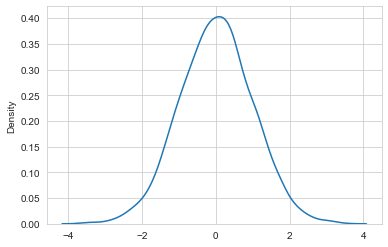

In [2]:
### Draw a large vector of random numbers by standard normal distribution
random_numbers = np.random.normal(loc=0.0, scale=1.0, size=3000)
### Now suppose we wanted to approximate the density function of those random numbers, we suppose
### the kernel density estimate to look like the standard normal distribution
sns.set_style("whitegrid")
sns.kdeplot(random_numbers)

## How the Random Art Algorithm works ##

A neural network is mostly used as classification or regression model.  
Suppose we have some input data $\mathbf{x_i}$ and want to predict the outcome $\mathbf{y_i}$ where $\mathbf{x_i}$ is a vector of dimension $p$ and $\mathbf{y_i}$ a vector of dimension $k$.  
In this case we have a classification problem predicting one of the possible classes $k$.  
  
For the art generation, depending on which *colormode* we want to select ([classic RGB](https://en.wikipedia.org/wiki/RGB_color_model), [Grayscale](https://en.wikipedia.org/wiki/Grayscale), [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model) and [HSL or HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)), in the **output-layer** we have either 3,1,4 or 3 **output-neurons**.  
Since (for float) those colour-values are in the range $[0,1]$ the weigted input to each output-neuron will be transformed with a [sigmoid activation function](http://mathworld.wolfram.com/SigmoidFunction.html) as depicted below.

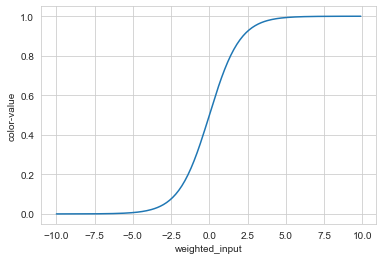

In [3]:
x = np.arange(-10, 10, 0.1)
sigmoid = 1 / (1 + np.exp(-x))
plt.plot(x, sigmoid)
plt.xlabel("weighted_input")
plt.ylabel("color-value")
plt.show()

For the hidden layer activations one can select different [activation functions](https://en.wikipedia.org/wiki/Activation_function) but since we map the `weighted_input` via sigmoid and want to create a variety range of colour-values between approx. 0.25 and 0.75, for each hidden layer the [tanh activation](http://mathworld.wolfram.com/HyperbolicTangent.html) will be used as depicted below. Note that this implementation by default selects those activation functions. I wrote a `FeedForwardNet`-class which can select different hidden layer neurons and layer activations (but for the output layer make sure the activation functions maps into range $[0,1]$) through the input paramter-lists `layers_dims` and `activations_fnc`.  

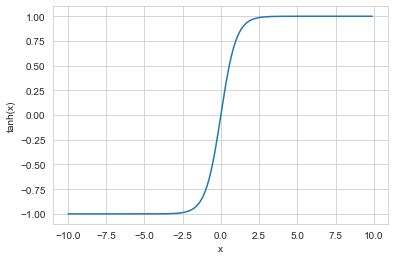

In [4]:
x = np.arange(-10, 10, 0.1)
tanh = np.tanh(x)
plt.plot(x, tanh)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.show()

The algorithm also incorporates the [alpha channel](https://en.wikipedia.org/wiki/Alpha_compositing) which determines the degree of transparency and opacity. When a color (source) is blended with another color (background), e.g., when an image is overlaid onto another image, the alpha value of the source color is used to determine the resulting color. If the alpha value is opaque, the source color overwrites the destination color; if transparent, the source color is invisible, allowing the background color to show through. If the value is in between, the resulting color has a varying degree of transparency/opacity, which creates a translucent effect. 

The color-values in the output layer will be generated by computing a **forward-pass** of input data. For that reason, it is straightforward to implement a `NeuralNet`-class with its needed methods for this case:

In [5]:
from nnetart.network import FeedForwardNetwork

## Input arguments for the random art generation ##

As user one must define which size the generated image ought have, hence `image_height` and `image_width` is necessary.  
Additionally one must define which `colormode` to use and whether or not the `alpha`-channel should be used.  
  
For the output image a `numpy.ndarray` will be used to represent the image. The image shape will be `(img_height, img_width, 4)`. If you are familiar with image-processing or convolutional neural nets often the shape `(img_height, img_width, 3)` appears. In case we have a grayscale image, the image will is actually a 2D-tensor. For grayscale images we can obtain the RGB-shape by simply copying each value of the initial gray scale into each dimension of the 3rd axis of the RGB image, e.g via [np.resize](https://docs.scipy.org/doc/numpy/reference/generated/numpy.resize.html):
```python
height, width = 256, 256
img = np.zeros((height,width))
nchannels = 3
new_img = np.resize(img, (height, width, nchannels))
```

Now so far so good. But our generated image has 4 channels in the 3rd dimension. This comes from modelling the `alpha`-channel. By default we just create this defined image shape but in case we do not want to include the alpha-channel-random-modelling for each pixel in the image the outputted alpha value will be 1 (meaning full opacity), e.g RGBA simply becomes to RGB.  
  
For the `colormode`  for `"CMYK", "HSV", "HSL"` (all being outputted to range $[0,1]$) those values will be converted to `RGB` format because for the image displaying and saving we assume an RGB classic image. The javascript code was mainly taken from [David Ha's Blogpost](http://blog.otoro.net/2015/06/19/neural-network-generative-art/) and rewritten in python.  
For a detailed conversion have a look at those sites: [CMYK to RGB](https://www.rapidtables.com/convert/color/cmyk-to-rgb.html), [HSV to RGB](https://www.rapidtables.com/convert/color/hsv-to-rgb.html) and [HSL to RGB](https://www.rapidtables.com/convert/color/hsl-to-rgb.html).

## Network Params and inputs ##
For the neural network we need to define the input dimensions, layers and activation functions.  
As input we will have a $5-dimensional$ vector. Suppose we have an image of size `(256,256)` and think of it as a 2D matrix. What the algorithm does is for each pixel `p_{i,j}` to compute the r,g,b,a values.  
Hence when generating each r,g,b,a value for each pixel in the generated image (computing in a 2-nested for loop) as input we will take:  

$$ x = \frac{i}{factor} - 0.5 \\
y = \frac{j}{factor}   - 0.5 \\
r = \sqrt{x^2 + y^2} \\
z_1 = uniform(low=-1, high=1) \\
z_2 = uniform(low=-1, high=1)\\ 
$$
  
where $factor= min(img_{height}, img_{width})$  and leading to $input_{i,j} = (x, y, r, z_{1}, z_{2}$)'

Interdependencies and correlation of the input data in the result image will be created by mapping the $x$, $y$ and $r$ value in a nested for loop:
```python:
for i in range(img_height):
    for j in range(img_width):
        x = i/factor - 0.5
        y = j/factor - 0.5
        r = np.sqrt(x*x + y*y)
        z1 = np.random.uniform(-1,1)
        z2 = np.random.uniform(-1,1)
        ...
```
Note that through the nested loop, $x$ and $y$ will be dependent and in case of square (img_height=img_width) resulting images the input data components $x$ and $y$ will always be smaller than 1. 
The $r$ value is a [circle equation](https://en.wikipedia.org/wiki/Circle).

## Example  NNet Params for art generation ##

In [6]:
n_depth = 4
n_size = 10
activation = "tanh"
colormode = "rgb"
alpha = True
nnet = FeedForwardNetwork(layers_dims = [n_size] * n_depth,
                          activation_fnc=activation,
                          colormode=colormode,
                          alpha=alpha)

In [7]:
print(nnet)

FeedForwardNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
  (activation): Tanh()
)


### Network Architecture ###
Image generated with http://alexlenail.me/NN-SVG/index.html:

<left>
<img src='https://raw.githubusercontent.com/tuanle618/neural-net-random-art/master/nn.png' alt="Neural Net Architecture" align="left">
</left>

## Populating the image with r,g,b,a values ##
Here the function is written in a seperate python script at `nnetart/artgen.py` and includes further operations to populate the input images wrt. the `z1` and `z2` variables instead of just drawing from random numbers.

In [8]:
from nnetart.artgen import init_data, transform_colors

In [9]:
input_img = init_data(img_height=500,
                      img_width=700,
                      symmetry=False,
                      trig=True,
                      z1=-0.618,
                      z2=0.618,
                      noise=False,
                      noise_std=0.01)

In [10]:
print(input_img.shape)

torch.Size([350000, 5])


## Generate Image function ##

Main points of the function:
1. initializes output image
2. initializes network parameters (layers and activations) if not inserted via dictionary `nnet_dict` with keys `layers` and `activations_fnc`
3. iterates through rows and columns from image to populate r,g,b,a values

In [11]:
def generate_image_torch(my_net: FeedForwardNetwork = FeedForwardNetwork(),
                         img_height=512,
                         img_width=512,
                         symmetry=False,
                         trig=True,
                         colormode="rgb",
                         alpha=False,
                         z1=-0.618, z2=0.618,
                         show=True,
                         fname="netart",
                         format="png",
                         save=True,
                         gpu=False,
                         with_noise=False,
                         noise_std=0.01):
    input_data = init_data(img_height, img_width, symmetry, trig, z1, z2, noise=with_noise, noise_std=noise_std)
    if gpu:
        input_data = input_data.cuda()
        my_net = my_net.cuda()

    with torch.no_grad():
        img = my_net(input_data)

    if gpu:
        img = img.cpu()

    img = img.view(img_height, img_width, img.size(-1))
    img = transform_colors(img, colormode, alpha)
    img = img.numpy()        
    if not show:
        matplotlib.use("Agg")
    plt.figure()
    fig = plt.imshow(img, interpolation="bilinear", aspect="auto")
    plt.axis("off")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if show:
        plt.show()
    if save:
        plt.imsave(f"{fname}.{format}", img, format=format)
    return img


## Run the algorithm with randomized settings: ##

In [12]:
## This is fix
img_height = img_width = 256
activation = "tanh"

In [13]:
def randomize_configs():
    n_size = int(np.random.randint(low=8, high=20, size=1))
    n_depth = int(np.random.randint(low=3, high=8, size=1))
    alpha = bool(np.random.choice(a=[True, False], size=1))
    colormode = np.random.choice(a=["rgb", "bw", "cmyk", "hsl", "hsv"], size=1)[0]
    z1 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    z2 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    trig = int(np.random.randint(low=0, high=2, size=1))
    trig = bool(trig)
    
    return n_size, n_depth, colormode, alpha, z1, z2, trig

In [14]:
n_images = 10
if not os.path.exists("nb_output"):
    os.makedirs("nb_output")

### Run the algorithm 10 times with random configs and save the results in `nb_output` subdir ###

Settings:
n_size: 17
n_depth: 7
colormode: bw
alpha: False
z1: -0.34774
z2: 0.45016
trig: True
--------
Generated image: 1


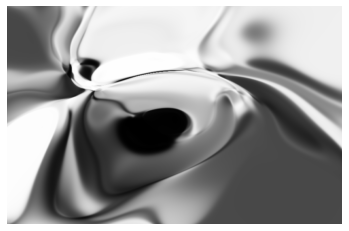

Generating image 1 took 0.2218780517578125 seconds
Settings:
n_size: 15
n_depth: 6
colormode: rgb
alpha: False
z1: -0.30716
z2: -0.35555
trig: True
--------
Generated image: 2


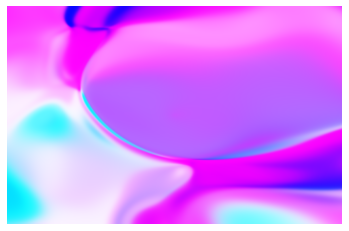

Generating image 2 took 0.19630789756774902 seconds
Settings:
n_size: 16
n_depth: 4
colormode: hsv
alpha: False
z1: 0.61513
z2: -0.47507
trig: True
--------
Generated image: 3


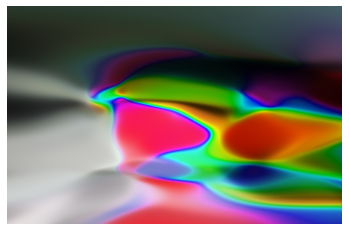

Generating image 3 took 1.1745719909667969 seconds
Settings:
n_size: 18
n_depth: 6
colormode: hsl
alpha: False
z1: 0.3086
z2: -0.95301
trig: True
--------
Generated image: 4


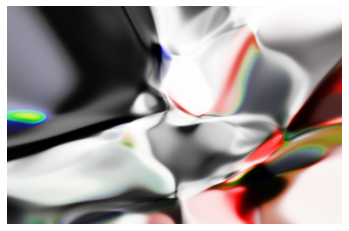

Generating image 4 took 3.3475821018218994 seconds
Settings:
n_size: 16
n_depth: 4
colormode: hsv
alpha: True
z1: -0.79443
z2: -0.62646
trig: False
--------
Generated image: 5


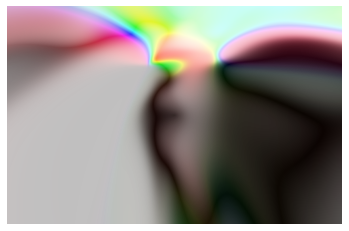

Generating image 5 took 1.2066690921783447 seconds
Settings:
n_size: 19
n_depth: 3
colormode: cmyk
alpha: True
z1: 0.12606
z2: -0.81177
trig: True
--------
Generated image: 6


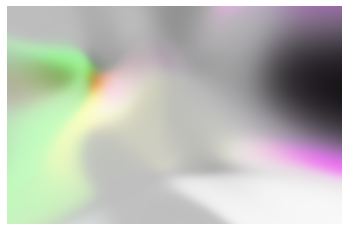

Generating image 6 took 0.21925926208496094 seconds
Settings:
n_size: 10
n_depth: 5
colormode: hsv
alpha: True
z1: -0.41633
z2: 0.76517
trig: False
--------
Generated image: 7


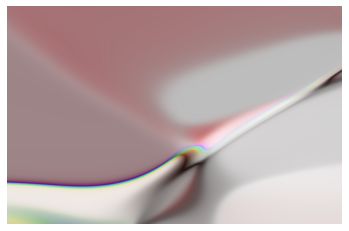

Generating image 7 took 1.222951889038086 seconds
Settings:
n_size: 15
n_depth: 7
colormode: rgb
alpha: True
z1: 0.67927
z2: -0.33875
trig: True
--------
Generated image: 8


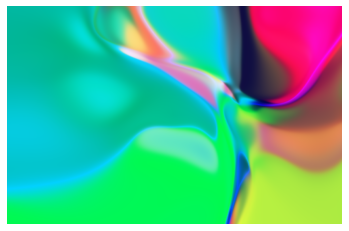

Generating image 8 took 0.2533590793609619 seconds
Settings:
n_size: 16
n_depth: 5
colormode: hsv
alpha: False
z1: 0.73304
z2: -0.8366
trig: False
--------
Generated image: 9


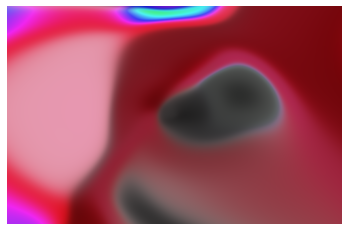

Generating image 9 took 1.201019287109375 seconds
Settings:
n_size: 13
n_depth: 6
colormode: hsv
alpha: False
z1: 0.34147
z2: -0.61321
trig: False
--------
Generated image: 10


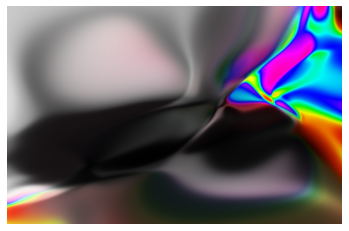

Generating image 10 took 1.2773971557617188 seconds


In [15]:
for i in range(n_images):
    n_size, n_depth, colormode, alpha, z1, z2, trig = randomize_configs()
    print("Settings:")
    print("n_size: {}".format(n_size))
    print("n_depth: {}".format(n_depth))
    print("colormode: {}".format(colormode))
    print("alpha: {}".format(alpha))
    print("z1: {}".format(z1))
    print("z2: {}".format(z2))
    print("trig: {}".format(trig))
    print("--------")
    fname = "nb_output/generated_{}.png".format(i+1)
    print("Generated image: {}".format(i+1))
    start_time = time.time()
    my_net = FeedForwardNetwork([n_size]*n_depth, alpha=alpha, colormode=colormode, activation_fnc=activation)
    generate_image_torch(my_net,
                         img_height=512,
                         img_width=512,
                         symmetry=False,
                         trig=trig,
                         colormode=colormode,
                         alpha=alpha,
                         z1=z1, z2=z2,
                         show=True,
                         fname=fname,
                         format="png",
                         save=True,
                         gpu=False,
                         with_noise=False,
                         noise_std=0.01)
    delta = time.time() - start_time
    print("Generating image {} took {} seconds".format(i+1, delta))

### Generate an image with defined network parameters ###
As mentioned one can define the hidden layer size and neurons within the hidden layers via the `layers` list.  
Make sure the first element of the `layers`-list is 5 (because of the 5 input values). Hence `layers[0] = 5`  
In case of `cmyk` colormode the output neuron size ought to be 4. Hence `layers[-1]=4`  
For all other colormodes `rgb, bw, hsv, hsl` the output neurons ought to be 3. Hence `layers[-1]=3`  
If the alpha channel should be used as well, the outputlayer needs to be imcremented by 1. Hence `layers[-1] +=1`

In [16]:
img_height = img_width = 512
colormode = "rgb"
alpha = False
activations_fnc = "softsign"
layers = [5, 10, 8, 18, 13, 4]
z1 = -0.99
z2 = 0.85

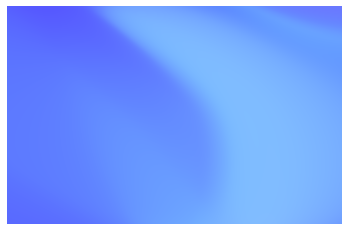

Generating image took 0.1844022274017334 seconds


In [17]:
net = FeedForwardNetwork(layers, activation_fnc=activations_fnc, alpha=alpha)
start_time = time.time()
generate_image_torch(net, img_height=img_height, img_width=img_width,
                     colormode=colormode, alpha=alpha, z1=z1, z2=z2,
                     show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [18]:
img_height = img_width = 512
colormode = "hsv"
alpha = True
activations_fnc = "tanh"
layers = [5, 10, 20, 18, 25, 3]
z1 = -0.45
z2 = 0.66

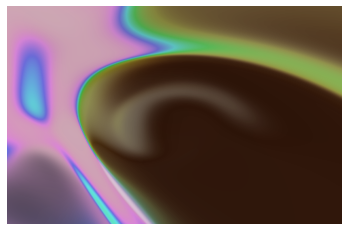

Generating image took 1.2853620052337646 seconds


In [19]:
start_time = time.time()
net = FeedForwardNetwork(layers, activation_fnc=activations_fnc, alpha=alpha)
start_time = time.time()
generate_image_torch(net, img_height=img_height, img_width=img_width,
                     colormode=colormode, alpha=alpha, z1=z1, z2=z2,
                     show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [20]:
img_height = img_width = 512
colormode = "bw"
alpha = False
activations_fnc = "softsign"
layers = [5, 10, 30, 40, 50, 3]
z1 = 0.255
z2 = 0.900

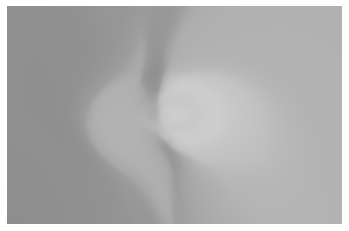

Generating image took 0.3346848487854004 seconds


In [21]:
net = FeedForwardNetwork(layers, activation_fnc=activations_fnc, alpha=alpha)
start_time = time.time()
generate_image_torch(net, img_height=img_height, img_width=img_width,
                     colormode=colormode, alpha=alpha, z1=z1, z2=z2,
                     show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [22]:
img_height = img_width = 512
colormode = "hsl"
alpha = False
activations_fnc = "sin"
layers = [5, 20, 10, 30, 40, 3]
z1 = 0.255
z2 = 0.900

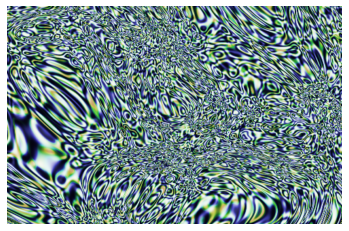

Generating image took 3.2351911067962646 seconds


In [23]:
net = FeedForwardNetwork(layers, activation_fnc=activations_fnc, alpha=alpha)
start_time = time.time()
generate_image_torch(net, img_height=img_height, img_width=img_width,
                     colormode=colormode, alpha=alpha, z1=z1, z2=z2,
                     show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

# End #